In [1]:
import sys
import os
os.getcwd()
sys.path.insert(0,"/notebooks") ###link the fast AI package

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

!python -m spacy download en
# spacy.load('en')
# spacy_en = spacy.load('en')

import pandas as pd
import json
import random

    100% |################################| 37.4MB 78.5MB/s ta 0:00:011
  Running setup.py install for en-core-web-sm ... done
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /opt/conda/envs/fastai/lib/python3.6/site-packages/en_core_web_sm -->
    /opt/conda/envs/fastai/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



### Convert JSON files of Trump tweets to individual text files

In [38]:
PATH='/notebooks/courses/dl1/data/corpus/'

#PATH='data/trump_tweet_data_archive/'

if not os.path.exists(PATH + 'models'):
    os.mkdir(PATH + 'models')
    
if not os.path.exists(PATH + 'train'):
    os.mkdir(PATH + 'train')

if not os.path.exists(PATH + 'valid'):
    os.mkdir(PATH + 'valid')

TRN_PATH = 'train/'
VAL_PATH = 'valid/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

README.md  models/  text/  train/  trump_campaign_corpus.json  valid/


In [4]:
filename = 'trump_campaign_corpus.json'

with open(PATH + filename) as data_file:
    df = pd.read_json(data_file.read())
    print(df.shape)
            
df.head()

(5394, 15)


,completeness,date_created,date_published,doc,doc_orig,event,genre,is_as_spoken,is_public_domain,location,people,publisher,text_filename,title,twitter_source
0,complete,None,Mon Jun 15 11:12:50 -0500 2015,"{'person': 'Donald Trump', 'p': 'Tomorrow will...","{'person': 'Donald Trump', 'p': 'Tomorrow will...",None,tweet,0.0,NaN,"{'venue': None, 'city': None, 'state': None, '...","[{'person': 'Donald Trump', 'role': 'speaker',...","{'show': None, 'media_org': 'twitter'}","2015-06-15 11.12.50 (Complete, As written) Twe...",None,Twitter for Android
1,complete,None,Mon Jun 15 16:33:32 -0500 2015,"{'person': 'Donald Trump', 'p': 'Will do, than...","{'person': 'Donald Trump', 'p': 'Will do, than...",None,tweet,0.0,NaN,"{'venue': None, 'city': None, 'state': None, '...","[{'person': 'Donald Trump', 'role': 'speaker',...","{'show': None, 'media_org': 'twitter'}","2015-06-15 16.33.32 (Complete, As written) Twe...",None,Twitter Web Client
2,complete,None,Tue Jun 16 11:00:00 -0500 2015,"[{'person': 'Donald Trump', 'p': ['Wow. Whoa. ...",None,Presidential Candidacy Announcement,speech,1.0,NaN,"{'venue': None, 'city': 'New York', 'state': '...","[{'person': 'Donald Trump', 'role': 'speaker',...","{'show': None, 'media_org': None}","2015-06-16 11.00.00 (Complete, As spoken) Spee...",None,None
3,complete,None,Tue Jun 16 11:00:00 -0500 2015,"{'person': 'Donald Trump', 'p': ['Our country ...",None,Presidential Candidacy Announcement,speech,0.0,NaN,"{'venue': None, 'city': 'New York', 'state': '...","[{'person': 'Donald Trump', 'role': 'speaker',...","{'show': None, 'media_org': None}","2015-06-16 11.00.00 (Complete, As written) Spe...",None,None
4,complete,None,Tue Jun 16 12:20:40 -0500 2015,"{'person': 'Donald Trump', 'p': 'Big time in U...","{'person': 'Donald Trump', 'p': 'Big time in U...",None,tweet,0.0,NaN,"{'venue': None, 'city': None, 'state': None, '...","[{'person': 'Donald Trump', 'role': 'speaker',...","{'show': None, 'media_org': 'twitter'}","2015-06-16 12.20.40 (Complete, As written) Twe...",None,Twitter for Android


In [45]:
to_validation_pct = 0.25

for index, row in df.iterrows():
    if index < 3:
        if row['genre'] == 'speech':
            speech_str = ''
            for x in row['doc']:
                if type(x) is dict:
                    if x['person'] == 'Donald Trump':
                        for y in x['p']:
                            if type(y) is str:
                                print(y)
                                speech_str = speech_str + ' ' + y
#                 elif True: #type(x) is str:
#                     print(type(x))
                            
            if random.random() > to_validation_pct: 
                with open(TRN + str(index) + ".txt", "w") as text_file:
                    print(speech_str, file=text_file)
            else:
                with open(VAL + str(index) + ".txt", "w") as text_file:
                    print(speech_str, file=text_file)
                        
            # df_speech = pd.read_json(row['doc'])
            
# print(speech_str)
#df_speech.head()

Wow. Whoa. That is some group of people. Thousands.
So nice, thank you very much. That's really nice. Thank you. It's great to be at Trump Tower. It's great to be in a wonderful city, New York. And it's an honor to have everybody here. This is beyond anybody's expectations. There's been no crowd like this.
And, I can tell, some of the candidates, they went in. They didn't know the air-conditioner didn't work. They sweated like dogs.
They didn't know the room was too big, because they didn't have anybody there. How are they going to beat ISIS? I don't think it's gonna happen.
Our country is in serious trouble. We don't have victories anymore. We used to have victories, but we don't have them. When was the last time anybody saw us beating, let's say, China in a trade deal? They kill us. I beat China all the time. All the time.
When did we beat Japan at anything? They send their cars over by the millions, and what do we do? When was the last time you saw a Chevrolet in Tokyo? It doesn't e

## Language modeling

### Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; that is, a model that can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (predict the next word), and fine tune it to do something else (classify sentiment).

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. To follow along with this notebook, we suggest downloading the dataset from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

Let's look inside the training folder...

In [46]:
trn_files = !ls {TRN}
trn_files[:10]

['1011.txt',
 '1069.txt',
 '1076.txt',
 '1254.txt',
 '1511.txt',
 '1652.txt',
 '1687.txt',
 '1710.txt',
 '172.txt',
 '1741.txt']

...and at an example review.

In [48]:
review = !cat {TRN}{trn_files[5]}
review[0]

' This is really beautiful, fantastic. What a crowd. What a crowd. Well, I want to thank everybody. You know, we have a big night tomorrow night. Has anybody, like, thinking about it? It\'s going be good. We\'ve had so many good things happen over the last five-month period, it\'s been actually amazing. The people of this country are absolutely incredible people and I am honored to be with you tonight. It\'s like this all over the place. We\'re going to take our country back, folks. We\'re going to take it back. We\'re taking our country back. It\'s gone on too long, too many mistakes, too many stupid people telling us what we\'re supposed to be doing. We\'re going to be taking it back and we\'re taking it back soon. We can\'t put up with it any longer. You see what happens. The Iran deal, incompetent. Anything you look, now I hear Bergdahl, no jail time for Bergdahl. I mean, no jail time. We have a man there who left. He\'s a traitor. He left. Five people killed looking for him. And w

Sounds like I'd really enjoy *Zombiegeddon*...

Now we'll check how many words are in the dataset.

In [49]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

644900


In [50]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

168105


Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

In [51]:
spacy_tok = spacy.load('en')

In [52]:
' '.join([sent.string.strip() for sent in spacy_tok(review[0])])

' This is really beautiful , fantastic . What a crowd . What a crowd . Well , I want to thank everybody . You know , we have a big night tomorrow night . Has anybody , like , thinking about it ? It \'s going be good . We \'ve had so many good things happen over the last five - month period , it \'s been actually amazing . The people of this country are absolutely incredible people and I am honored to be with you tonight . It \'s like this all over the place . We \'re going to take our country back , folks . We \'re going to take it back . We \'re taking our country back . It \'s gone on too long , too many mistakes , too many stupid people telling us what we \'re supposed to be doing . We \'re going to be taking it back and we \'re taking it back soon . We ca n\'t put up with it any longer . You see what happens . The Iran deal , incompetent . Anything you look , now I hear Bergdahl , no jail time for Bergdahl . I mean , no jail time . We have a man there who left . He \'s a traitor . 

In [53]:
spacy_tok(review[0])

 This is really beautiful, fantastic. What a crowd. What a crowd. Well, I want to thank everybody. You know, we have a big night tomorrow night. Has anybody, like, thinking about it? It's going be good. We've had so many good things happen over the last five-month period, it's been actually amazing. The people of this country are absolutely incredible people and I am honored to be with you tonight. It's like this all over the place. We're going to take our country back, folks. We're going to take it back. We're taking our country back. It's gone on too long, too many mistakes, too many stupid people telling us what we're supposed to be doing. We're going to be taking it back and we're taking it back soon. We can't put up with it any longer. You see what happens. The Iran deal, incompetent. Anything you look, now I hear Bergdahl, no jail time for Bergdahl. I mean, no jail time. We have a man there who left. He's a traitor. He left. Five people killed looking for him. And what happens? L

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [54]:
TEXT = data.Field(lower=True, tokenize="spacy")

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also not have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

In [55]:
bs=64; bptt=70

In [56]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [57]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [58]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(174, 3043, 1, 787998)

This is the start of the mapping from integer IDs to unique tokens.

In [59]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', ',', 'the', 'and', 'to', 'i', 'we', 'a', 'you', 'it']

In [60]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

4

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [61]:
[md.trn_ds[0].text[:12]]

[[' ',
  'i',
  "'m",
  'going',
  'to',
  'be',
  'back',
  'here',
  'so',
  'much',
  ',',
  'you']]

torchtext will handle turning this words into integer IDs for us automatically.

In [62]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
  394
    7
   54
   18
    6
   32
   86
   92
   26
  108
    3
   10
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [63]:
next(iter(md.trn_dl))

(Variable containing:
   394    18  1289  ...     91  1267     5
     7     6   113  ...     59    10   192
    54    32     0  ...      4   167  2069
        ...          ⋱          ...       
    14  1540     5  ...     38    18   209
   123    57    61  ...     13     6   205
   210    12     4  ...     68   186    48
 [torch.cuda.LongTensor of size 69x64 (GPU 0)], Variable containing:
     7
     6
   113
   ⋮  
     0
    25
    29
 [torch.cuda.LongTensor of size 4416 (GPU 0)])

### Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [64]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [65]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [66]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As you can see below, I gradually tuned the language model in a few stages. I possibly could have trained it further (it wasn't yet overfitting), but I didn't have time to experiment more. Maybe you can see if you can train it to a better accuracy! (I used `lr_find` to find a good learning rate, but didn't save the output in this notebook. Feel free to try running it yourself now.)

In [67]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      5.061863   4.823403  
    1      4.362948   4.073439                              
    2      4.079154   3.939788                              
    3      3.891141   3.697113                              
    4      3.643698   3.515472                              
    5      3.490644   3.429876                              
    6      3.420022   3.412999                              
    7      3.446908   3.364478                              
    8      3.309707   3.28492                               
    9      3.172821   3.228229                              
    10     3.073549   3.194465                              
    11     2.959769   3.166232                              
    12     2.913606   3.149642                              
    13     2.86006    3.146755                              
    14     2.819492   3.148902                              



[array([3.1489])]

In [68]:
learner.save_encoder('adam1_enc')

In [69]:
learner.load_encoder('adam1_enc')

In [29]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

epoch      trn_loss   val_loss                              
    0      3.855831   4.168963  
    1      3.841275   4.148924                              
    2      3.746623   4.1457                                
    3      3.6419     4.148001                              
    4      3.550224   4.157631                              
    5      3.433506   4.185609                              
    6      3.366927   4.193138                              
    7      3.314364   4.195596                              
    8      3.266821   4.213211                              
    9      3.274691   4.212482                              



[array([4.21248])]

In [30]:
learner.save_encoder('adam3_10_enc')
#learner.load_cycle('adam3_10',2)

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [31]:
learner.save_encoder('adam3_20_enc')

In [32]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [70]:
math.exp(4.165)

64.3926824434624

In [71]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [72]:
TEXT.vocab.stoi['the']

4

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [73]:
def tokenizer(text): # create a tokenizer function
    return [tok for tok in spacy_en.tokenizer(text)]

In [ ]:
#tokenizer("this is interesting")

In [107]:
m=learner.model

ss={}
ss[0]=[['kanye']]
ss[1]=[['look','forward']]
ss[2]=[['look','at','what']]
ss[3]=[['crooked']]
ss[4]=[['huge']]
ss[5]=[['thank','you','to','all']]
ss[6]=[['ive','got','a','lot','of','problems','with','you','people']]


#s = [spacy_tok(ss)]
#sss = [spacy_tok(ss)]
# print(ss)

s = ss[0]
print(s)

t=TEXT.numericalize(s)
t
# ' '.join(s[0])
#' '.join([sent.string.strip() for sent in spacy_tok(s[0])])

[['crooked']]


Variable containing:
 413
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [109]:
        
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [110]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['hillary', '<eos>', ' ', 'trump', 'j.', 'i', 'clinton', 'we', 'bush', 'obama']

...and let's see if our model can generate a bit more text all by itself!

In [111]:
print(s,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

[['crooked']] 

hillary clinton 's plan will be a disaster for the american people . she wants to raise your taxes . we 're going to eliminate every unnecessary job - killing regulation . we will cancel every illegal obama executive order . we will cancel every illegal obama executive order . ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [ ]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [ ]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

In [ ]:
t = splits[0].examples[0]

In [ ]:
t.label, ' '.join(t.text[:16])

fastai can create a ModelData object directly from torchtext splits.

In [ ]:
md2 = TextData.from_splits(PATH, splits, bs)

In [ ]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [ ]:
m3.clip=25.
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [ ]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy_np(*m3.predict_with_targs())

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

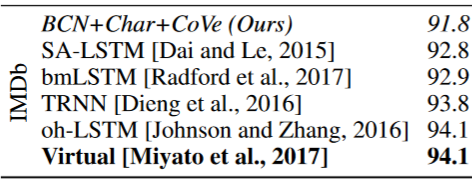

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

### End